In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.video_io import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir

### Set up recording location and duration info

In [3]:
import datetime

In [4]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2022-02-07_14-29-37'

In [5]:
filename_prefix = DATA_DIR / 'test_recording' / timestamp
recording_length = 10

In [6]:
ensure_dir(filename_prefix)

### Get camera information

In [7]:
!k4arecorder --list

Index:0	Serial:000779510512	Color:1.6.110	Depth:1.6.79


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)

In [8]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [9]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            "synchronized_images_only": False,
            #"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": False,
        },
    }
}

### Testing

In [10]:
from multiprocessing import Process, Queue
from kinectacq.video_io import capture_from_azure 

In [11]:
device_name = "master"

In [12]:
devices[device_name]["id"]

0

In [13]:
devices[device_name]["pyk4a_config"]

{'color_resolution': <ColorResolution.RES_720P: 1>,
 'depth_mode': <DepthMode.NFOV_UNBINNED: 2>,
 'synchronized_images_only': False}

In [14]:
k4a_obj = PyK4A(
    Config(**devices[device_name]["pyk4a_config"]),
    device_id=devices[device_name]["id"],
)

In [15]:
k4a_obj

In [16]:
k4a_obj.start()

In [17]:
capture = k4a_obj.get_capture()

In [18]:
np.shape(capture.depth)

(576, 640)

In [19]:
np.shape(capture.ir)

(576, 640)

<ipython-input-20-37f53f763c51>:2: RuntimeWarning: divide by zero encountered in log
  ax1.matshow(np.log(capture.ir+1))


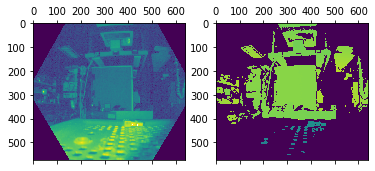

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.matshow(np.log(capture.ir+1))
ax2.matshow(np.log(capture.depth+1))

(array([2.64816e+05, 8.43580e+04, 1.63420e+04, 3.11400e+03, 9.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([    0. ,  1358.7,  2717.4,  4076.1,  5434.8,  6793.5,  8152.2,
         9510.9, 10869.6, 12228.3, 13587. ]),
 <BarContainer object of 10 artists>)

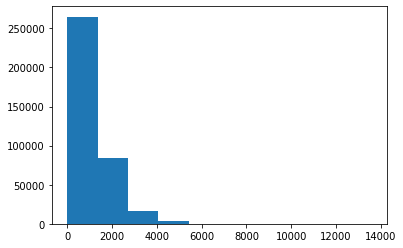

In [21]:
plt.hist(capture.depth.flatten())

In [22]:
depth = capture.depth

In [23]:
depth_pipe = None

In [24]:
from kinectacq.video_io import write_frames  

In [26]:
!ls /home/tim/Projects/azure_acquisition_template/data/test_recording/2022-02-07_14-24-15

test.depth.avi


In [27]:
write_frames(
    filename_prefix / "test.depth.avi",
    depth.astype(np.uint8)[None, :, :],
    codec="ffv1",
    close_pipe=False,
    pipe=depth_pipe,
)

In [28]:
k4a_obj.stop()